In [1]:
# Setup and Imports
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import warnings

# Model Training
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)

# --- Configuration ---
DB_PATH = '../../dataset/supervised_dataset.duckdb'
LABELED_TABLE = 'labeled_training_data_new_approach'
SUPERVISED_MODEL_SAVE_PATH = "../../models/supervised/XGBClassifier_model.pkl"

sns.set_theme(style="whitegrid")

warnings.filterwarnings('ignore') 

In [2]:
# Load Labeled Data
print(f"Loading labeled data from '{LABELED_TABLE}'...")
try:
    con = duckdb.connect(database=DB_PATH, read_only=True)
    df = con.query(f"SELECT * FROM {LABELED_TABLE}").to_df()
    con.close()
    
    # Ensure is_insider is int
    df['is_insider'] = df['is_insider'].astype(int)
    
    print("Data loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    print(df['is_insider'].value_counts())

except Exception as e:
    print(f"--- CRITICAL ERROR: Could not load data ---")
    print(f"Error: {e}")
    raise

Loading labeled data from 'labeled_training_data_new_approach'...
Data loaded successfully.
Dataset shape: (1000, 38)
is_insider
0    930
1     70
Name: count, dtype: int64


In [3]:
# Define Features (X) and Target (y)
print("\nDefining features (X) and target (y)...")

# The target 'y' is our label
y = df['is_insider']

X = df.drop(columns=['user_id', 'is_insider'])

# Save feature names for later
feature_names = X.columns.tolist()

print(f"  Features shape (X): {X.shape}")
print(f"  Target shape (y):   {y.shape}")


Defining features (X) and target (y)...
  Features shape (X): (1000, 36)
  Target shape (y):   (1000,)


In [4]:
# Create Train-Test Split
print("\nCreating stratified 80/20 train-test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,     
    random_state=42,     
    stratify=y          # <-- Ensures class imbalance is maintained
)

print(f"  Training features: {X_train.shape}")
print(f"  Testing features:  {X_test.shape}")
print("\nTraining set distribution:")
print(y_train.value_counts())
print("\nTesting set distribution:")
print(y_test.value_counts()) 


Creating stratified 80/20 train-test split...
  Training features: (800, 36)
  Testing features:  (200, 36)

Training set distribution:
is_insider
0    744
1     56
Name: count, dtype: int64

Testing set distribution:
is_insider
0    186
1     14
Name: count, dtype: int64


In [5]:
# Handle Class Imbalance

# Calculate the ratio: count(benign) / count(insider)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"\nCalculated 'scale_pos_weight' for imbalance: {scale_pos_weight:.2f}")


Calculated 'scale_pos_weight' for imbalance: 13.29


In [6]:
# Train the XGBClassifier Model
print("\nTraining XGBClassifier...")

# Initialize the model
model = XGBClassifier(
    objective='binary:logistic',  # For binary 0/1 classification
    scale_pos_weight=scale_pos_weight, # Our imbalance parameter
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

print("Model training complete.")


Training XGBClassifier...
Model training complete.


In [7]:
# Saving the trained model
print(f"\nSaving trained model to '{SUPERVISED_MODEL_SAVE_PATH}'...")
try:
    with open(SUPERVISED_MODEL_SAVE_PATH, 'wb') as f:
        pickle.dump(model, f)
    print("Model saved successfully.")
except Exception as e:
    print(f"--- ERROR: Could not save model ---")
    print(f"Error: {e}")


Saving trained model to '../../models/supervised/XGBClassifier_model.pkl'...
Model saved successfully.


In [8]:
# 7. EVALUATION 1: Classification Report (Precision, Recall, F1)
# This is our main performance summary.
#
# - Precision: Of the users we flagged, how many were *really* insiders?
# - Recall:    Of all *real* insiders, how many did we *find*?
# - F1-Score:  The balanced average of Precision and Recall.
#
# We care most about the scores for **Class 1 (Insider)**.

print("\n--- EVALUATION 1: Classification Report (on Test Set) ---")
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Benign (0)", "Insider (1)"]))



--- EVALUATION 1: Classification Report (on Test Set) ---
              precision    recall  f1-score   support

  Benign (0)       0.97      0.98      0.98       186
 Insider (1)       0.75      0.64      0.69        14

    accuracy                           0.96       200
   macro avg       0.86      0.81      0.84       200
weighted avg       0.96      0.96      0.96       200




--- EVALUATION 2: Confusion Matrix ---


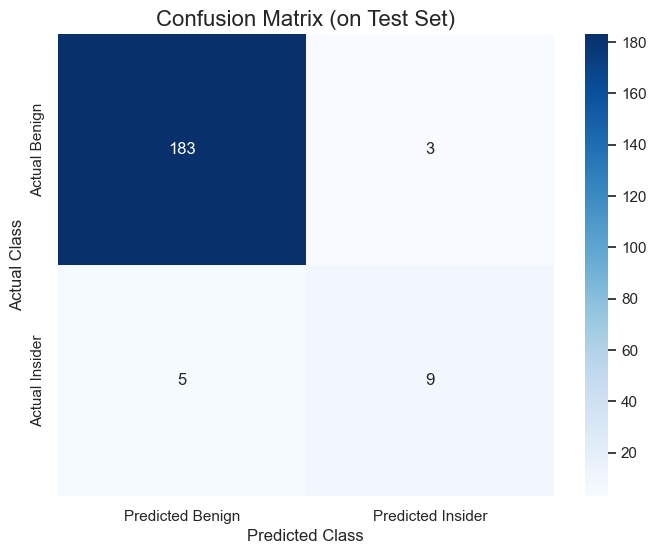

In [9]:
# 8. EVALUATION 2: Confusion Matrix
# A visual breakdown of the Classification Report.
#
# - True Negative (Top-Left):  Benign users we correctly
#                              called "Benign".
# - False Positive (Top-Right): Benign users we *incorrectly*
#                               called "Insider". (Analyst fatigue)
# - False Negative (Bottom-Left): Insiders we *missed*. (The worst case!)
# - True Positive (Bottom-Right): Insiders we correctly *found*.

print("\n--- EVALUATION 2: Confusion Matrix ---")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d', # Integer formatting
    cmap='Blues',
    xticklabels=["Predicted Benign", "Predicted Insider"],
    yticklabels=["Actual Benign", "Actual Insider"]
)
plt.title('Confusion Matrix (on Test Set)', fontsize=16)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()



--- EVALUATION 3: Precision-Recall Curve ---


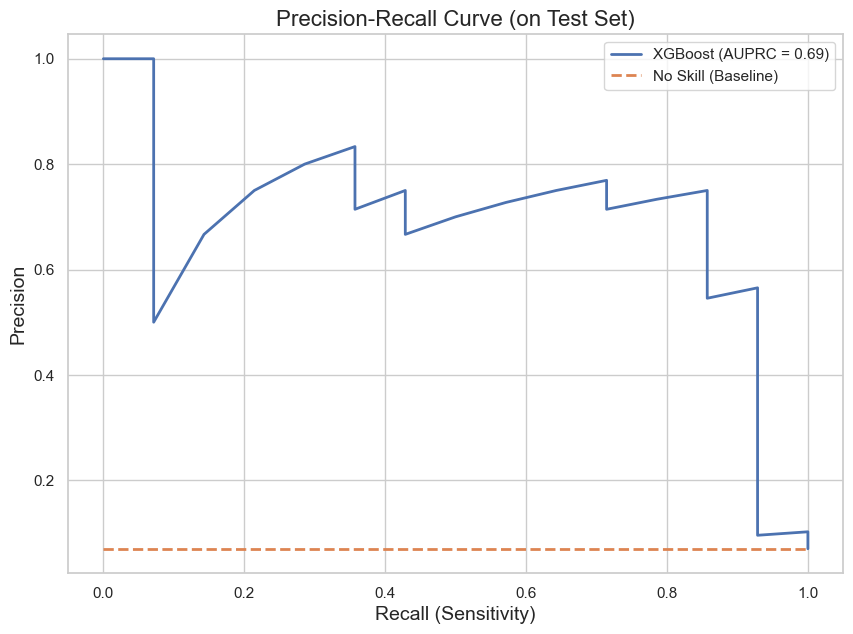

Area Under Precision-Recall Curve (AUPRC): 0.6879


In [10]:
# 9. EVALUATION 3: Precision-Recall Curve (AUPRC)
# For imbalanced data, this is the best plot to show
# the model's "skill" at all possible alert thresholds.
#
# A "dumb" model would be a flat line near the bottom.
# A "skillful" model (like ours) will be in the top-right.

print("\n--- EVALUATION 3: Precision-Recall Curve ---")

# Get prediction probabilities for the "Insider" class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, lw=2, label=f'XGBoost (AUPRC = {pr_auc:.2f})')
# Calculate baseline (no-skill) line
no_skill = (y_test == 1).sum() / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', lw=2, label='No Skill (Baseline)')

plt.xlabel('Recall (Sensitivity)', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve (on Test Set)', fontsize=16)
plt.legend(loc='best')
plt.show()

print(f"Area Under Precision-Recall Curve (AUPRC): {pr_auc:.4f}")



--- EVALUATION 4: Feature Importance ---


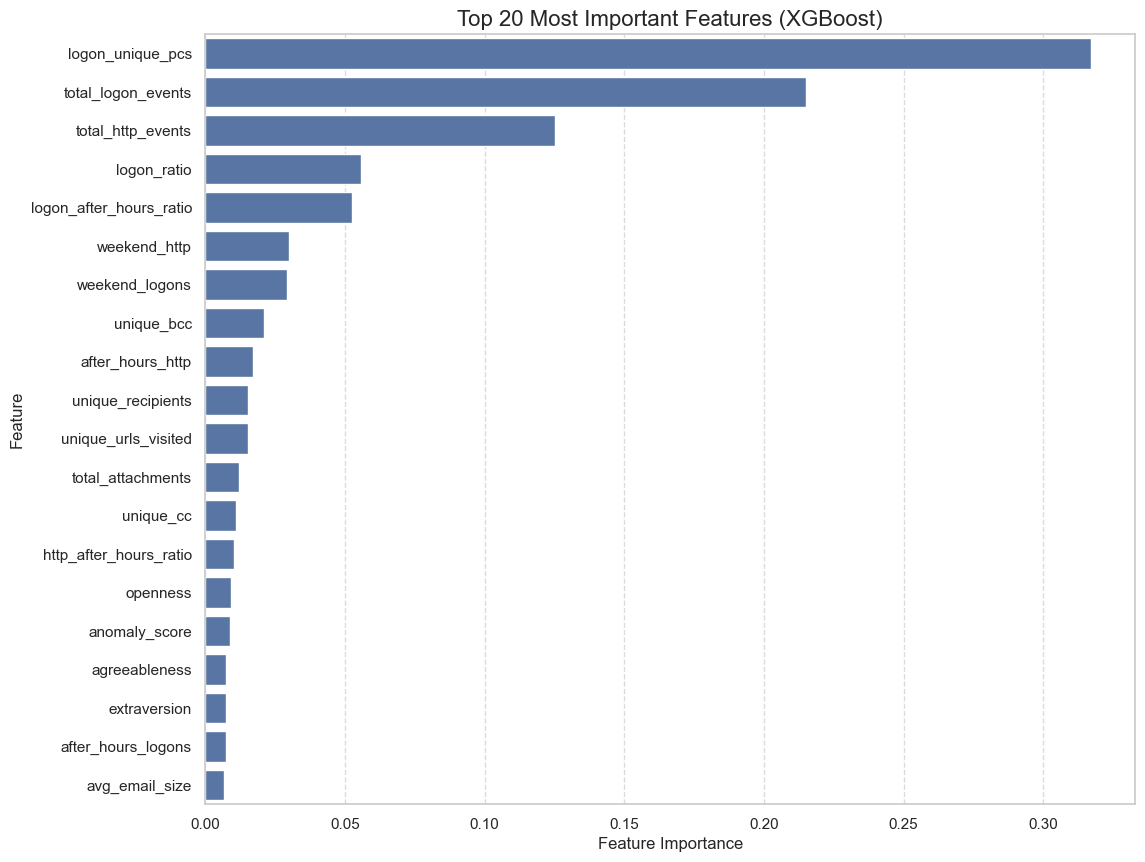

In [11]:
# 10. EVALUATION 4: Feature Importance
# This is the "Why?".
#
# This plot tells us which features the model used most
# to make its decisions. This is the final validation
# of our entire EDA and feature engineering process.

print("\n--- EVALUATION 4: Feature Importance ---")

# Get importances
importances = model.feature_importances_
# Create a DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df.head(20) # Show top 20
)
plt.title('Top 20 Most Important Features (XGBoost)', fontsize=16)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()